## Setup

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
work_dir = "/content/drive/My Drive/Colab Notebooks/Assignment9/"
os.chdir(work_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Activation, Reshape
import matplotlib.pyplot as plt
import numpy as np
from keras import models
from keras.models import Sequential, Model

## Load the CIFAR-10 dataset

In [ ]:
(train_images_initial, train_labels_initial), (test_images_initial, test_labels_initial) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(train_images_initial)}")
print(f"Total test examples: {len(test_images_initial)}")

# normalize data
train_images = train_images_initial.astype('float32')
test_images = test_images_initial.astype('float32')
train_images /= 255
test_images /= 255

train_labels = train_labels_initial.reshape((-1))
test_labels = test_labels_initial.reshape((-1))

Total training examples: 50000
Total test examples: 10000


# MLP Autoencoder

In [ ]:
## Encoder
ip = Input(shape=(32,32,3))
fc1 = Dense(512)(ip)
act1 = Activation('relu')(fc1)
fc2 = Dense(256)(act1)
act2 = Activation('relu')(fc2)
fc3 = Dense(256)(act2)
act3 = Activation('relu')(fc3)
fc4 = Dense(128)(act3)
code = Activation('relu')(fc4)

## Decoder
fc5 = Dense(256)(code)
act4 = Activation('relu')(fc5)
fc6 = Dense(train_images.shape[-1])(act4)

act_op_relu = Activation('relu')(fc6)
act_op_sigmoid = Activation('sigmoid')(fc6)

In [ ]:
autoencoder_MLP1 = Model(ip, act_op_relu)
autoencoder_MLP1.compile(loss=keras.losses.mean_squared_error, optimizer='adam',metrics=['accuracy'])

In [ ]:
autoencoder_MLP2 = Model(ip, act_op_sigmoid)
autoencoder_MLP2.compile(loss=keras.losses.binary_crossentropy, optimizer='adam',metrics=['accuracy'])

In [ ]:
# Uses ReLU
autoencoder_MLP1.fit(train_images, train_images,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_images))

Epoch 1/10
391/391 [==============================] - 104s 264ms/step - loss: 0.0138 - accuracy: 0.8220 - val_loss: 5.9471e-06 - val_accuracy: 0.9792
Epoch 2/10
391/391 [==============================] - 102s 262ms/step - loss: 7.9913e-06 - accuracy: 0.9433 - val_loss: 1.5736e-06 - val_accuracy: 0.9462
Epoch 3/10
391/391 [==============================] - 102s 262ms/step - loss: 9.0511e-06 - accuracy: 0.9457 - val_loss: 5.8253e-07 - val_accuracy: 0.9745
Epoch 4/10
391/391 [==============================] - 102s 262ms/step - loss: 8.3126e-06 - accuracy: 0.9494 - val_loss: 1.3070e-06 - val_accuracy: 0.9834
Epoch 5/10
391/391 [==============================] - 102s 262ms/step - loss: 7.4316e-06 - accuracy: 0.9488 - val_loss: 1.1534e-05 - val_accuracy: 0.9141
Epoch 6/10
391/391 [==============================] - 102s 262ms/step - loss: 1.1342e-05 - accuracy: 0.9507 - val_loss: 2.0866e-06 - val_accuracy: 0.9764
Epoch 7/10
391/391 [==============================] - 106s 272ms/step - loss: 1.

In [ ]:
#Uses sigmoid
autoencoder_MLP2.fit(train_images, train_images,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_images))

Epoch 1/10
391/391 [==============================] - 106s 268ms/step - loss: 0.5544 - accuracy: 0.8566 - val_loss: 0.5479 - val_accuracy: 0.9200
Epoch 2/10
391/391 [==============================] - 104s 266ms/step - loss: 0.5470 - accuracy: 0.9295 - val_loss: 0.5478 - val_accuracy: 0.9455
Epoch 3/10
391/391 [==============================] - 104s 266ms/step - loss: 0.5468 - accuracy: 0.9350 - val_loss: 0.5476 - val_accuracy: 0.9559
Epoch 4/10
391/391 [==============================] - 104s 266ms/step - loss: 0.5467 - accuracy: 0.9346 - val_loss: 0.5476 - val_accuracy: 0.9640
Epoch 5/10
391/391 [==============================] - 104s 265ms/step - loss: 0.5467 - accuracy: 0.9340 - val_loss: 0.5475 - val_accuracy: 0.9453
Epoch 6/10
391/391 [==============================] - 104s 265ms/step - loss: 0.5466 - accuracy: 0.9428 - val_loss: 0.5475 - val_accuracy: 0.9362
Epoch 7/10
391/391 [==============================] - 104s 265ms/step - loss: 0.5467 - accuracy: 0.9372 - val_loss: 0.5475 -

In [ ]:
#Creating subset for training
train_images_sub = train_images[0:5000]
print(train_images_sub.shape)
train_labels_sub = train_labels[0:5000]
print(train_labels_sub.shape)

(5000, 32, 32, 3)
(5000,)


In [ ]:
encoder_MLP = Model(autoencoder_MLP1.input, autoencoder_MLP1.get_layer(index=8).output)

# Freeze  MLP encoder(of trained autoencoder) and train classifier on top

In [ ]:
flat = tf.keras.layers.Flatten()(encoder_MLP.output)
classification = Dense(10, activation='softmax')(flat)
encoder_freeze_classifier_MLP = Model(encoder_MLP.input, classification)
for layer in encoder_MLP.layers[:-1]:
  layer.trainable = False

encoder_freeze_classifier_MLP.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 dense_12 (Dense)            (None, 32, 32, 512)       2048      
                                                                 
 activation_14 (Activation)  (None, 32, 32, 512)       0         
                                                                 
 dense_13 (Dense)            (None, 32, 32, 256)       131328    
                                                                 
 activation_15 (Activation)  (None, 32, 32, 256)       0         
                                                                 
 dense_14 (Dense)            (None, 32, 32, 256)       65792     
                                                                 
 activation_16 (Activation)  (None, 32, 32, 256)       0  

In [ ]:
encoder_freeze_classifier_MLP.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer='adam',metrics=['accuracy'])
encoder_freeze_classifier_MLP.fit(train_images_sub, train_labels_sub,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_labels))

Epoch 1/10
40/40 [==============================] - 10s 229ms/step - loss: 3.2377 - accuracy: 0.2264 - val_loss: 2.2236 - val_accuracy: 0.3019
Epoch 2/10
40/40 [==============================] - 9s 217ms/step - loss: 1.8328 - accuracy: 0.3556 - val_loss: 2.1102 - val_accuracy: 0.2769
Epoch 3/10
40/40 [==============================] - 9s 224ms/step - loss: 1.6987 - accuracy: 0.4010 - val_loss: 1.8928 - val_accuracy: 0.3431
Epoch 4/10
40/40 [==============================] - 8s 216ms/step - loss: 1.6292 - accuracy: 0.4306 - val_loss: 2.4850 - val_accuracy: 0.2609
Epoch 5/10
40/40 [==============================] - 9s 216ms/step - loss: 1.7847 - accuracy: 0.3904 - val_loss: 2.0376 - val_accuracy: 0.3221
Epoch 6/10
40/40 [==============================] - 9s 216ms/step - loss: 1.5781 - accuracy: 0.4566 - val_loss: 1.9296 - val_accuracy: 0.3625
Epoch 7/10
40/40 [==============================] - 8s 215ms/step - loss: 1.5499 - accuracy: 0.4670 - val_loss: 2.0462 - val_accuracy: 0.3212
Epoch

# Without freezing encoding layers and adding classifier

In [ ]:
flat = tf.keras.layers.Flatten()(encoder_MLP.output)
classification = Dense(10, activation='softmax')(flat)
encoder_freeze_classifier_MLP = Model(encoder_MLP.input, classification)
encoder_freeze_classifier_MLP.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 dense_12 (Dense)            (None, 32, 32, 512)       2048      
                                                                 
 activation_14 (Activation)  (None, 32, 32, 512)       0         
                                                                 
 dense_13 (Dense)            (None, 32, 32, 256)       131328    
                                                                 
 activation_15 (Activation)  (None, 32, 32, 256)       0         
                                                                 
 dense_14 (Dense)            (None, 32, 32, 256)       65792     
                                                                 
 activation_16 (Activation)  (None, 32, 32, 256)       0  

In [ ]:
encoder_freeze_classifier_MLP.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer='adam',metrics=['accuracy'])
encoder_freeze_classifier_MLP.fit(train_images_sub, train_labels_sub,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_labels))

Epoch 1/10
40/40 [==============================] - 10s 229ms/step - loss: 3.0141 - accuracy: 0.2394 - val_loss: 1.8754 - val_accuracy: 0.3381
Epoch 2/10
40/40 [==============================] - 9s 217ms/step - loss: 1.8144 - accuracy: 0.3602 - val_loss: 1.9689 - val_accuracy: 0.3108
Epoch 3/10
40/40 [==============================] - 9s 217ms/step - loss: 1.6821 - accuracy: 0.4042 - val_loss: 2.2289 - val_accuracy: 0.2812
Epoch 4/10
40/40 [==============================] - 9s 217ms/step - loss: 1.6888 - accuracy: 0.4152 - val_loss: 1.9940 - val_accuracy: 0.3569
Epoch 5/10
40/40 [==============================] - 9s 217ms/step - loss: 1.6433 - accuracy: 0.4434 - val_loss: 1.9075 - val_accuracy: 0.3481
Epoch 6/10
40/40 [==============================] - 8s 216ms/step - loss: 1.5458 - accuracy: 0.4558 - val_loss: 1.9176 - val_accuracy: 0.3414
Epoch 7/10
40/40 [==============================] - 9s 217ms/step - loss: 1.5518 - accuracy: 0.4540 - val_loss: 1.9754 - val_accuracy: 0.3503
Epoch

# Observation for MLP Autoencoder: 
We have trained two similar auto encoder networks, one with ReLU activation in the final decode output layer and one with Sigmoid. It is oberved that the architecture with relu output is performing better than the other one in terms of validation accuracy.

We notice that accuracy of model with frozen encoded layers performed better than the model without freezing layers.


# Convolutional Autoencoders

In [ ]:
#encoder
input_lyr = tf.keras.layers.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(input_lyr)#30
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)#28
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)#14
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)#12
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)#6

#decoder
x = tf.keras.layers.UpSampling2D((2, 2))(encoded)#12
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)#14
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)#28
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x) #30
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(x) #32
x = tf.keras.layers.BatchNormalization()(x)
decoded = tf.keras.layers.Activation('relu')(x)


In [ ]:
autoencoder_CONV = tf.keras.Model(input_lyr, decoded)
autoencoder_CONV.compile(optimizer='adam', loss='mse', metrics= ['accuracy'])

In [ ]:
autoencoder_CONV.save_weights(work_dir+'Auto_Encoder.ckpt')
chk_pt = tf.keras.callbacks.ModelCheckpoint(filepath=work_dir,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
autoencoder_CONV.fit(train_images, train_images,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_images))

Epoch 1/10
391/391 [==============================] - 27s 48ms/step - loss: 0.0232 - accuracy: 0.6081 - val_loss: 0.0147 - val_accuracy: 0.6404
Epoch 2/10
391/391 [==============================] - 18s 46ms/step - loss: 0.0077 - accuracy: 0.7079 - val_loss: 0.0069 - val_accuracy: 0.7376
Epoch 3/10
391/391 [==============================] - 18s 45ms/step - loss: 0.0058 - accuracy: 0.7403 - val_loss: 0.0048 - val_accuracy: 0.7562
Epoch 4/10
391/391 [==============================] - 18s 45ms/step - loss: 0.0048 - accuracy: 0.7564 - val_loss: 0.0043 - val_accuracy: 0.7698
Epoch 5/10
391/391 [==============================] - 18s 45ms/step - loss: 0.0045 - accuracy: 0.7629 - val_loss: 0.0037 - val_accuracy: 0.7757
Epoch 6/10
391/391 [==============================] - 18s 46ms/step - loss: 0.0039 - accuracy: 0.7751 - val_loss: 0.0035 - val_accuracy: 0.7879
Epoch 7/10
391/391 [==============================] - 18s 46ms/step - loss: 0.0036 - accuracy: 0.7814 - val_loss: 0.0038 - val_accuracy:

In [ ]:
encoder_Con = Model(autoencoder_CONV.input, autoencoder_CONV.get_layer(index=11).output)

# Freeze Conv encoder(of trained autoencoder) and train classifier on top

In [ ]:
flat = tf.keras.layers.Flatten()(encoder_Con.output)
classification = Dense(10, activation='softmax')(flat)
encoder_freeze_classifier_conv = Model(encoder_Con.input, classification)
for layer in encoder_Con.layers[:-1]:
  layer.trainable = False

encoder_freeze_classifier_conv.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation_21 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                          

In [ ]:
encoder_freeze_classifier_conv.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer='adam',metrics=['accuracy'])

encoder_freeze_classifier_conv.fit(train_images_sub, train_labels_sub,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_labels))

Epoch 1/10
40/40 [==============================] - 2s 41ms/step - loss: 2.3093 - accuracy: 0.2500 - val_loss: 1.9447 - val_accuracy: 0.3193
Epoch 2/10
40/40 [==============================] - 1s 26ms/step - loss: 1.7503 - accuracy: 0.3878 - val_loss: 1.7041 - val_accuracy: 0.4006
Epoch 3/10
40/40 [==============================] - 1s 26ms/step - loss: 1.5794 - accuracy: 0.4478 - val_loss: 1.6479 - val_accuracy: 0.4267
Epoch 4/10
40/40 [==============================] - 1s 26ms/step - loss: 1.4527 - accuracy: 0.4954 - val_loss: 1.5709 - val_accuracy: 0.4500
Epoch 5/10
40/40 [==============================] - 1s 26ms/step - loss: 1.3967 - accuracy: 0.5118 - val_loss: 1.5176 - val_accuracy: 0.4706
Epoch 6/10
40/40 [==============================] - 2s 43ms/step - loss: 1.3017 - accuracy: 0.5480 - val_loss: 1.7562 - val_accuracy: 0.3963
Epoch 7/10
40/40 [==============================] - 2s 43ms/step - loss: 1.3223 - accuracy: 0.5396 - val_loss: 1.6333 - val_accuracy: 0.4346
Epoch 8/10
40

# Without freezing encoding layers and adding classifier

In [ ]:
flat = tf.keras.layers.Flatten()(encoder_Con.output)
classification = Dense(10, activation='softmax')(flat)
encoder_freeze_classifier_conv = Model(encoder_Con.input, classification)

encoder_freeze_classifier_conv.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation_21 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                          

In [ ]:
encoder_freeze_classifier_conv.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer='adam',metrics=['accuracy'])

encoder_freeze_classifier_conv.fit(train_images_sub, train_labels_sub,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_labels))

Epoch 1/10
40/40 [==============================] - 2s 38ms/step - loss: 2.3507 - accuracy: 0.2324 - val_loss: 1.9749 - val_accuracy: 0.3134
Epoch 2/10
40/40 [==============================] - 1s 26ms/step - loss: 1.7742 - accuracy: 0.3770 - val_loss: 1.8522 - val_accuracy: 0.3727
Epoch 3/10
40/40 [==============================] - 1s 26ms/step - loss: 1.6293 - accuracy: 0.4334 - val_loss: 1.6602 - val_accuracy: 0.4127
Epoch 4/10
40/40 [==============================] - 1s 25ms/step - loss: 1.4857 - accuracy: 0.4764 - val_loss: 1.6144 - val_accuracy: 0.4414
Epoch 5/10
40/40 [==============================] - 1s 26ms/step - loss: 1.4161 - accuracy: 0.5018 - val_loss: 1.5717 - val_accuracy: 0.4470
Epoch 6/10
40/40 [==============================] - 1s 26ms/step - loss: 1.3365 - accuracy: 0.5294 - val_loss: 1.6619 - val_accuracy: 0.4194
Epoch 7/10
40/40 [==============================] - 1s 26ms/step - loss: 1.2974 - accuracy: 0.5452 - val_loss: 1.5426 - val_accuracy: 0.4618
Epoch 8/10
40

# No pretraining

In [ ]:
input = tf.keras.layers.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(input)#30
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)#28
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)#14
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)#12
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)#6
flat = tf.keras.layers.Flatten()(encoded)
clfn = Dense(10, activation='softmax')(flat)

my_classifier = Model(input, clfn)
my_classifier.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer='adam',metrics=['accuracy'])

my_classifier.fit(train_images_sub, train_labels_sub,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_labels))

Epoch 1/10
40/40 [==============================] - 3s 47ms/step - loss: 2.0999 - accuracy: 0.2888 - val_loss: 2.2990 - val_accuracy: 0.1795
Epoch 2/10
40/40 [==============================] - 1s 35ms/step - loss: 1.5754 - accuracy: 0.4382 - val_loss: 2.5230 - val_accuracy: 0.1030
Epoch 3/10
40/40 [==============================] - 1s 35ms/step - loss: 1.4229 - accuracy: 0.4968 - val_loss: 2.8003 - val_accuracy: 0.1149
Epoch 4/10
40/40 [==============================] - 1s 36ms/step - loss: 1.3144 - accuracy: 0.5428 - val_loss: 2.9458 - val_accuracy: 0.1010
Epoch 5/10
40/40 [==============================] - 1s 35ms/step - loss: 1.2046 - accuracy: 0.5742 - val_loss: 3.1283 - val_accuracy: 0.1127
Epoch 6/10
40/40 [==============================] - 1s 35ms/step - loss: 1.0876 - accuracy: 0.6134 - val_loss: 3.0497 - val_accuracy: 0.1276
Epoch 7/10
40/40 [==============================] - 1s 35ms/step - loss: 0.9996 - accuracy: 0.6538 - val_loss: 2.6342 - val_accuracy: 0.1602
Epoch 8/10
40

# Observations for Conv Autoencoder

The model without freezing encoded layers performed better than the one with frozen layers which is quite opposite to how MLP model performed.

Also, model without pretraining has the least performance.

# Denoising Conv Autoencoder

**Functions for data agumentation**





In [ ]:

noise_factor = 0.1
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape) 

train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)


**Data transformation after agumentation**

In [ ]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, num=6):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20,4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

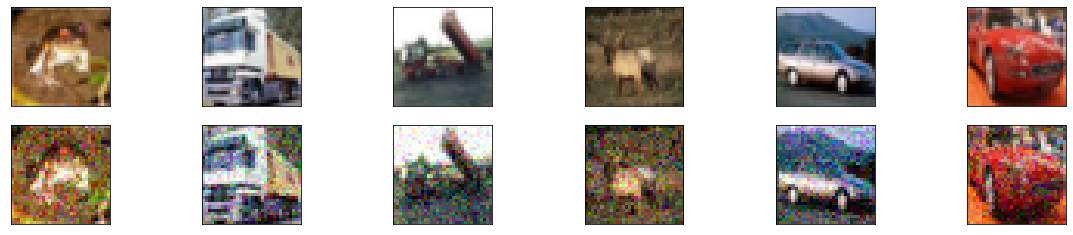

In [ ]:
showOrigDec(train_images, train_images_noisy)

**Training Denoising Conv Autoencoder**

In [ ]:
autoencoder_CONV.fit(train_images_noisy, train_images,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images_noisy, test_images))

Epoch 1/10
391/391 [==============================] - 19s 46ms/step - loss: 0.0245 - accuracy: 0.6019 - val_loss: 0.0153 - val_accuracy: 0.5823
Epoch 2/10
391/391 [==============================] - 19s 48ms/step - loss: 0.0085 - accuracy: 0.6953 - val_loss: 0.0069 - val_accuracy: 0.7014
Epoch 3/10
391/391 [==============================] - 18s 47ms/step - loss: 0.0064 - accuracy: 0.7227 - val_loss: 0.0056 - val_accuracy: 0.7283
Epoch 4/10
391/391 [==============================] - 18s 45ms/step - loss: 0.0056 - accuracy: 0.7354 - val_loss: 0.0050 - val_accuracy: 0.7530
Epoch 5/10
391/391 [==============================] - 18s 45ms/step - loss: 0.0051 - accuracy: 0.7436 - val_loss: 0.0051 - val_accuracy: 0.7550
Epoch 6/10
391/391 [==============================] - 18s 45ms/step - loss: 0.0048 - accuracy: 0.7468 - val_loss: 0.0065 - val_accuracy: 0.7100
Epoch 7/10
391/391 [==============================] - 18s 45ms/step - loss: 0.0046 - accuracy: 0.7514 - val_loss: 0.0045 - val_accuracy:

## Denoising Visualization

In [ ]:
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


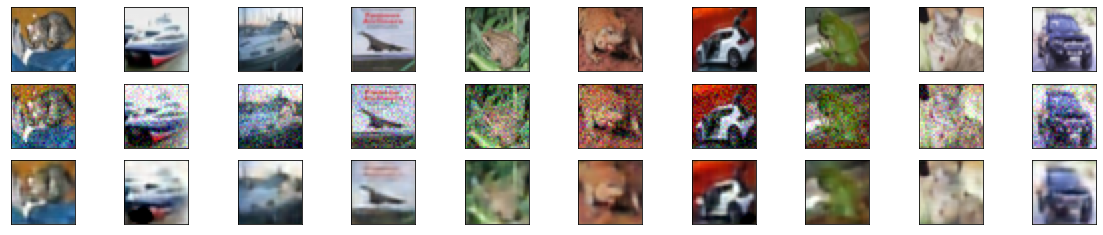

In [ ]:
denoised_images = autoencoder_CONV.predict(test_images_noisy)
# model.load_weights(work_dir+'Auto_Encoder.hdf5')

showOrigDec(test_images,test_images_noisy,denoised_images)


## Adding classification head after the encoder

In [ ]:
encoder_Con = Model(autoencoder_CONV.input, autoencoder_CONV.get_layer(index=11).output)
flat = tf.keras.layers.Flatten()(encoder_Con.output)
classification = Dense(10, activation='softmax')(flat)
encoder_freeze_classifier_conv = Model(encoder_Con.input, classification)
for layer in encoder_Con.layers[:-1]:
  layer.trainable = False

encoder_freeze_classifier_conv.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_27 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                          

In [ ]:
encoder_freeze_classifier_conv.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer='adam',metrics=['accuracy'])

encoder_freeze_classifier_conv.fit(train_images_sub, train_labels_sub,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_labels))

Epoch 1/10
40/40 [==============================] - 2s 36ms/step - loss: 2.3193 - accuracy: 0.2380 - val_loss: 1.9403 - val_accuracy: 0.3286
Epoch 2/10
40/40 [==============================] - 1s 25ms/step - loss: 1.7633 - accuracy: 0.3762 - val_loss: 1.7067 - val_accuracy: 0.4052
Epoch 3/10
40/40 [==============================] - 1s 26ms/step - loss: 1.5510 - accuracy: 0.4574 - val_loss: 1.6368 - val_accuracy: 0.4160
Epoch 4/10
40/40 [==============================] - 1s 25ms/step - loss: 1.4525 - accuracy: 0.4914 - val_loss: 1.6813 - val_accuracy: 0.4176
Epoch 5/10
40/40 [==============================] - 1s 26ms/step - loss: 1.4332 - accuracy: 0.4968 - val_loss: 1.5903 - val_accuracy: 0.4447
Epoch 6/10
40/40 [==============================] - 2s 45ms/step - loss: 1.3326 - accuracy: 0.5368 - val_loss: 1.6058 - val_accuracy: 0.4379
Epoch 7/10
40/40 [==============================] - 1s 26ms/step - loss: 1.2978 - accuracy: 0.5518 - val_loss: 1.5094 - val_accuracy: 0.4685
Epoch 8/10
40

# Without freezing encoding layers and adding classifier

In [ ]:
encoder_Con = Model(autoencoder_CONV.input, autoencoder_CONV.get_layer(index=11).output)
flat = tf.keras.layers.Flatten()(encoder_Con.output)
classification = Dense(10, activation='softmax')(flat)
encoder_freeze_classifier_conv = Model(encoder_Con.input, classification)
encoder_freeze_classifier_conv.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_27 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                          

In [ ]:
encoder_freeze_classifier_conv.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer='adam',metrics=['accuracy'])

encoder_freeze_classifier_conv.fit(train_images_sub, train_labels_sub,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_labels))

Epoch 1/10
40/40 [==============================] - 2s 40ms/step - loss: 2.1492 - accuracy: 0.2762 - val_loss: 1.8113 - val_accuracy: 0.3665
Epoch 2/10
40/40 [==============================] - 1s 28ms/step - loss: 1.6968 - accuracy: 0.4048 - val_loss: 1.7836 - val_accuracy: 0.3627
Epoch 3/10
40/40 [==============================] - 1s 27ms/step - loss: 1.5501 - accuracy: 0.4564 - val_loss: 1.5908 - val_accuracy: 0.4391
Epoch 4/10
40/40 [==============================] - 1s 27ms/step - loss: 1.4278 - accuracy: 0.4976 - val_loss: 1.5846 - val_accuracy: 0.4366
Epoch 5/10
40/40 [==============================] - 1s 26ms/step - loss: 1.3633 - accuracy: 0.5212 - val_loss: 1.6014 - val_accuracy: 0.4304
Epoch 6/10
40/40 [==============================] - 1s 27ms/step - loss: 1.3140 - accuracy: 0.5400 - val_loss: 1.5135 - val_accuracy: 0.4708
Epoch 7/10
40/40 [==============================] - 1s 27ms/step - loss: 1.2574 - accuracy: 0.5592 - val_loss: 1.4982 - val_accuracy: 0.4763
Epoch 8/10
40

# Observations for Denoising Conv Autoencoder:

The final validation accuracies of denoising conv autoencoder with and without freezing encoded layers are almost similar to the accuracies of normal conv autoencoder.
